In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso ,LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error ,r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline

In [ ]:
from sklearn.base import BaseEstimator
class ClfSwitcher(BaseEstimator):

    def __init__(self, estimator = LinearRegression()):
        """
        A Custom BaseEstimator that can switch between classifiers.
        :param estimator: sklearn object - The classifier
        """
        self.estimator = estimator

    def fit(self, X, y=None, **kwargs):
        self.estimator.fit(X, y)
        return self

    def predict(self, X, y=None):
        return self.estimator.predict(X)


pipeline = Pipeline(steps=[
    ('model',  ClfSwitcher())
])

In [ ]:
def plot_predict(y_test,predicted):
  A = np.array(y_test).reshape(-1, 1)
  B = predicted.reshape(-1, 1)

  print(type(predicted))
  print(type(y_test))
  plt.rcParams['figure.figsize'] = 16,5
  plt.figure()
  plt.plot(A[-100:], label="Real")
  plt.plot(B[-100:], label="Predicted")
  plt.legend()
  plt.title("score: real vs predicted")
  plt.ylabel("score")
  plt.xticks(())
  rmse = np.sqrt(mean_squared_error(y_test, predicted))

  print('RMSE: ',rmse)

  print('Variance score: %.2f' % r2_score(y_test, predicted))
  plt.show()

In [ ]:
def split(X,y):
  X_train, X_val, y_train, y_val = train_test_split(X,y,
                                                    test_size=0.2, random_state=42)

  print('Training Features Shape:', X_train.shape)
  print('Training Labels Shape:', y_train.shape)
  print('Testing Features Shape:', X_val.shape)
  print('Testing Labels Shape:', y_val.shape)
  return X_train,X_val,y_train,y_val

def results(X_train,y_train,X_val,y_val,estimator):
  best_=estimator
  best_.fit(X_train, y_train)

  y_predict=best_.predict(X_val)

  scoring = {'R2': 'r2',
           '-MSE': 'neg_mean_squared_error',
           '-MAE': 'neg_mean_absolute_error',
           'Max': 'max_error'}



  scores = cross_validate(best_,
                        X_train, y_train,
                      scoring=scoring,
                      cv=ShuffleSplit(n_splits=3, random_state=42),return_train_score=True)


  print('results')
  DF_cv_forest = pd.DataFrame(scores)
  display(DF_cv_forest)


  print('error rate on the test data')
  print('MSE: %.4f' % mean_squared_error(y_val,y_predict))
  print('RMSE: %.4f' % mean_squared_error(y_val,y_predict,squared=False))

  print('R2 : %.4f' %  r2_score(y_val,y_predict))


In [ ]:
import pandas as pd
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

In [ ]:
display(data.shape, target.shape)

(506, 13)

(506,)

In [ ]:
X_train,X_val,y_train,y_val=split(data,target)

Training Features Shape: (404, 13)
Training Labels Shape: (404,)
Testing Features Shape: (102, 13)
Testing Labels Shape: (102,)


In [ ]:

parameters_reg = [
    {
        'model': ( Lasso(),),
        'model__alpha': np.logspace(-1, 2, 10),
        'model__fit_intercept':[True,False]
    }
]

# search across 100 different combinations, and use all available cores
lasso_random= RandomizedSearchCV(estimator=pipeline, param_distributions=parameters_reg,
                              n_iter = 100, scoring='neg_mean_squared_error',
                              cv = 3, verbose=2, random_state=42, n_jobs=-1,
                              return_train_score=True)

# Fit the random search model
lasso_random.fit(X_train, y_train);

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 20 is smaller than n_iter=100. Running 20 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [ ]:
lasso_random.best_estimator_

Pipeline(steps=[('model', Lasso(alpha=0.1))])

In [ ]:
results( X_train=X_train,y_train=y_train,X_val=X_val,y_val=y_val,estimator=lasso_random.best_estimator_)


results


,fit_time,score_time,test_R2,train_R2,test_-MSE,train_-MSE,test_-MAE,train_-MAE,test_Max,train_Max
0,0.003729,0.001666,0.790052,0.732445,-13.754530,-23.877487,-2.913732,-3.429823,-9.274578,-26.688445
1,0.001544,0.010247,0.709885,0.736729,-11.362392,-24.133356,-2.617613,-3.471366,-8.005245,-26.577592
2,0.006018,0.001611,0.816409,0.722292,-22.872479,-22.941589,-3.498214,-3.346115,-13.813495,-26.375311


error rate on the test data
MSE: 25.1556
RMSE: 5.0155
R2 : 0.6570


#Random_Forest

In [ ]:

from sklearn.ensemble import  RandomForestRegressor
# Number of trees in random forest
n_estimators =[int(x) for x in np.linspace(1, 100, num = 20)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1,8, num = 8)]
#max_depth.append(None)
# Minimum number of samples required at each leaf node
min_samples_leaf = [int(x) for x in np.linspace(1, 100, num = 25)]
# Method of selecting samples for training each tree
bootstrap = [False,True]


parameters = [
  {
        'model': (RandomForestRegressor(),),
        'model__n_estimators': n_estimators,
        'model__max_features': max_features,
        'model__max_depth': max_depth,
        'model__min_samples_leaf': min_samples_leaf,
        'model__bootstrap': bootstrap,
    }
]

In [ ]:


# search across 100 different combinations, and use all available cores
rf_random= RandomizedSearchCV(estimator=pipeline, param_distributions=parameters,
                              n_iter = 100, scoring='neg_mean_squared_error',
                              cv = 3, verbose=2, random_state=42, n_jobs=-1,
                              return_train_score=True)

# Fit the random search model
rf_random.fit(X_train, y_train);

Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [ ]:
rf_random.best_estimator_

Pipeline(steps=[('model',
                 RandomForestRegressor(bootstrap=False, max_depth=8,
                                       max_features='sqrt', n_estimators=34))])

In [ ]:
results( X_train=X_train,y_train=y_train,X_val=X_val,y_val=y_val,estimator=rf_random.best_estimator_)


results


,fit_time,score_time,test_R2,train_R2,test_-MSE,train_-MSE,test_-MAE,train_-MAE,test_Max,train_Max
0,0.074002,0.004357,0.864540,0.985921,-8.874548,-1.256480,-2.098153,-0.841147,-11.409936,-4.670678
1,0.074959,0.008865,0.774651,0.987993,-8.825834,-1.100609,-2.222481,-0.804756,-9.183997,-4.078688
2,0.117728,0.004290,0.904265,0.986879,-11.927071,-1.083953,-2.443909,-0.783047,-11.353533,-4.793774


error rate on the test data
MSE: 10.1336
RMSE: 3.1833
R2 : 0.8618


#RERF

In [ ]:
base_predictions = lasso_random.predict(X_val)
base_predictions.shape

(102,)

In [ ]:
lasso_residuals = y_train - lasso_random.predict(X_train)
lasso_residuals.shape

(404,)

In [ ]:


# search across 100 different combinations, and use all available cores
rf_lasso_residual = RandomizedSearchCV(estimator=pipeline, param_distributions=parameters,
                              n_iter = 100, scoring='neg_mean_squared_error',
                              cv = 3, verbose=2, random_state=42, n_jobs=-1,
                              return_train_score=True)

# Fit the random search model
rf_lasso_residual.fit(X_train, lasso_residuals);

Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [ ]:
rf_lasso_residual.predict(X_val)[:3]

array([-1.99032762, -0.26414146,  0.58514863])

In [ ]:
base_predictions[:3]

array([28.4034798 , 33.98676148, 13.46016592])

In [ ]:
rf_residual_predictions =rf_lasso_residual.predict(X_val)

# Combine base predictions and RF predictions to get final predictions
final_predictions = base_predictions + rf_residual_predictions

error rate on the test data
MSE: 9.9373
RMSE: 3.1523
R2 : 0.8645
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
RMSE:  3.15234121664868
Variance score: 0.86


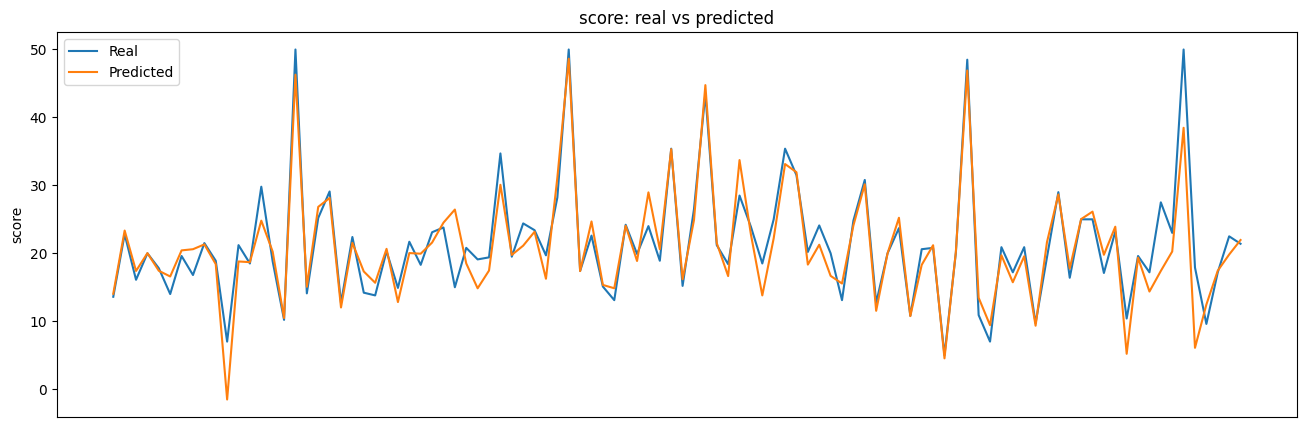

In [ ]:
print('error rate on the test data')
print('MSE: %.4f' % mean_squared_error(y_val,final_predictions))
print('RMSE: %.4f' % mean_squared_error(y_val,final_predictions,squared=False))

print('R2 : %.4f' %  r2_score(y_val,final_predictions))
plot_predict(y_val,final_predictions)

**The REFR (Random Enhanced Feature Reduction) algorithm has demonstrated remarkable performance in various machine learning tasks. In some scenarios, it outperforms traditional boosting algorithms and other machine learning techniques, showcasing its versatility and efficacy. The algorithm's unique approach to feature reduction, coupled with its ability to handle diverse datasets, often results in superior metrics compared to other methods. This makes REFR a promising choice for practitioners seeking optimal performance and robustness in their machine learning models.**